In [1]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
from scipy.stats import norm
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
top_level=f'{os.getcwd()}/..'

def datfile(filename):
    # Waveforms variables to be filled 
    ampFault = { i : []  for i in range(4) }  
    xPosFault = []
    yPosFault = []
    qBunchFault = []
    recordtime = []
    
    # Open the .dat file
    with fileio.FileReader(files=f'{top_level}/datfile/'+filename) as fd:
        
        # Loop through the file data
        for header,data in fd.records():
    
            # Check if there is a 8-byte header in the frame
            if (header.flags==0):
                hdrOffset = 8
                hdr = struct.unpack("<d", data[:8])[0]
                timestamp = time.localtime(hdr)
                # Define the desired format string (replace with your preferred format)
                # Some common format specifiers:
                # %Y - Year with century
                # %m - Month as a decimal number (01-12)
                # %d - Day of the month as a decimal number (01-31)
                # %H - Hour in 24-hour format (00-23)
                # %M - Minute (00-59)
                # %S - Second (00-59)
                
                formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S', timestamp)
                #print( f'CH={header.channel}: Event Timestamp in human-readable format: {formatted_time}' )
                if header.channel==24:
                    recordtime.append(formatted_time)
            
            else:
                hdrOffset = 0
                print( 'No timestamp header detected' )
            
            # Check for error in frame
            if (header.error>0):
                # Look at record header data
                print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
                print(f"Record size    = {header.size}")
                print(f"Record channel = {header.channel}")
                print(f"Record flags   = {header.flags:#x}")
                print(f"Record error   = {header.error:#x}")
    
            # Check if AMP Fault waveform
            elif (header.channel < 16) and (header.channel >= 12):
                ampFault[header.channel-12].append(data[hdrOffset:].view(np.int16))
    
            # Check if AMP Live waveform
            elif header.channel == 24:
                fpData = data[hdrOffset:].view(np.float32)
                fpDataLen = len(fpData)
                xPosFault.append(   fpData[0:(fpDataLen*3)+0:3] ) 
                yPosFault.append(   fpData[1:(fpDataLen*3)+1:3] )
                qBunchFault.append( fpData[2:(fpDataLen*3)+2:3] )
            
            # Else undefined stream index
            else:
                print( f'UNDEFINED DATA STREAM[{header.channel}]!!!')
    return ampFault, recordtime

6
2024-04-19_18-17-47


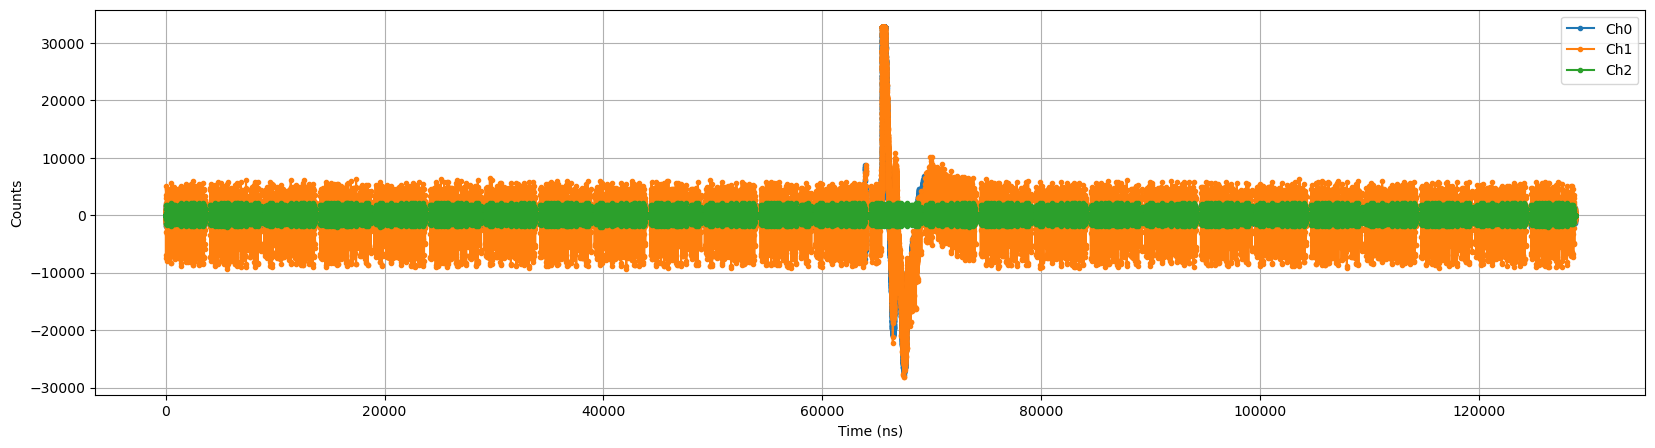

In [216]:
ampFault,recordtime=datfile("data_20240419_181524.dat")

print(len(recordtime))
eventnum=0
size = len(ampFault[0][eventnum])

print(recordtime[eventnum])
timeBin = 1.0/(0.509*8.0) # Unit of ns for 4.072 GSPS
timeSteps = np.linspace(0, timeBin*(size-1), num=size)

# Plot the Waveform Full Scale
plt.figure(figsize=(20,5))
start=23790
plt.plot(timeSteps,ampFault[0][eventnum],label="Ch0",marker='o',markersize=3)
plt.plot(timeSteps,ampFault[1][eventnum],label="Ch1",marker='o',markersize=3)
plt.plot(timeSteps,ampFault[2][eventnum],label="Ch2",marker='o',markersize=3)
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
#plt.xlim(0,150)
plt.legend()
plt.grid()

6
2024-04-19_18-17-51


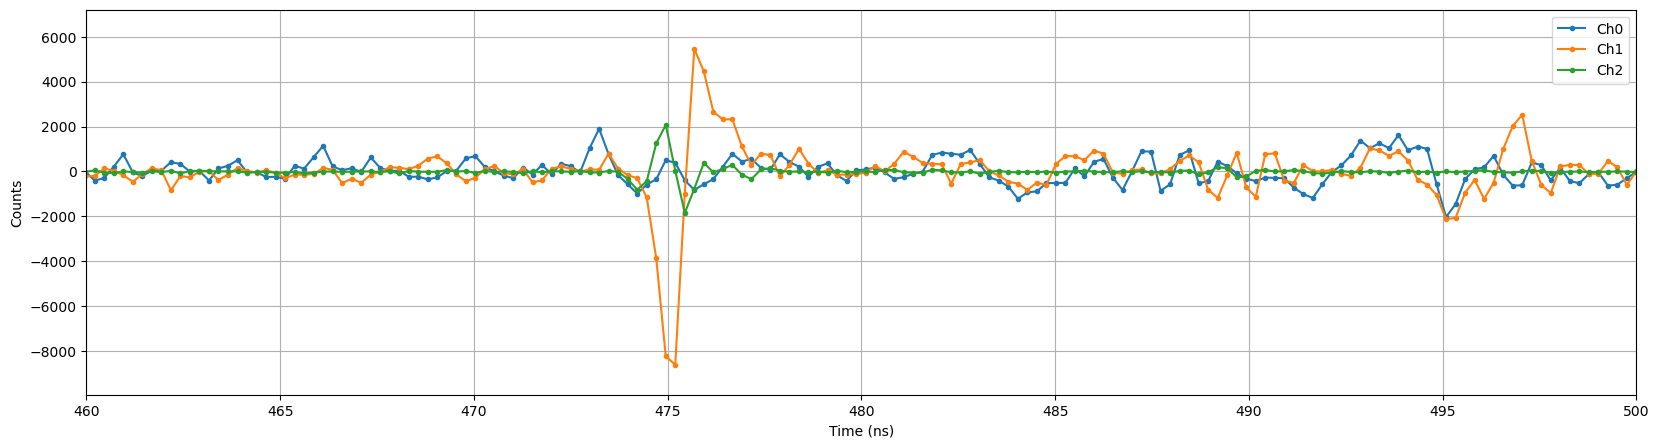

In [227]:
ampFault,recordtime=datfile("data_20240419_181524.dat")

print(len(recordtime))
eventnum=1
size = len(ampFault[0][eventnum])

print(recordtime[eventnum])
timeBin = 1.0/(0.509*8.0) # Unit of ns for 4.072 GSPS
timeSteps = np.linspace(0, timeBin*(size-1), num=size)

# Plot the Waveform Full Scale
plt.figure(figsize=(20,5))
start=23790
plt.plot(timeSteps,ampFault[0][eventnum],label="Ch0",marker='o',markersize=3)
plt.plot(timeSteps,ampFault[1][eventnum],label="Ch1",marker='o',markersize=3)
plt.plot(timeSteps,ampFault[2][eventnum],label="Ch2",marker='o',markersize=3)
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.xlim(460,500)
plt.legend()
plt.grid()

In [217]:
x=["175231","175106","174626","174218","173742","164750","172812","173206","173528"]
y=["183109","182922","182719","182138","181831","175758","181135","181339","181524"]

bamp=[-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]
measured_x=[]
measured_y=[]

for i in x:
    ampFault,recordtime=datfile("data_20240419_"+i+".dat")
    position=[]
    for eventnum in range(5):
        size = len(ampFault[0][eventnum])
        ch0=ampFault[0][eventnum]
        ch2=ampFault[2][eventnum]
        for k in range(size-2):
            if ch2[k]<ch2[k+1] and ch2[k+1]>ch2[k+2]:
                if ch2[k+1]>800:
                    position.append(ch0[k+1-6]/ch2[k+1])
        #print(eventnum,len(position))
    measured_x.append(position)

for i in y:
    ampFault,recordtime=datfile("data_20240419_"+i+".dat")
    position=[]
    for eventnum in range(5):
        size = len(ampFault[1][eventnum+1])
        ch1=ampFault[1][eventnum+1]
        ch2=ampFault[2][eventnum+1]
        for k in range(size-2):
            if ch2[k]<ch2[k+1] and ch2[k+1]>ch2[k+2]:
                if ch2[k+1]>800:
                    position.append(ch1[k+1+2]/ch2[k+1])
        #print(eventnum,len(position))
    measured_y.append(position)



In [218]:
#x=0mm data seems to be not valid. so use y=0mm
x0mm=[]
for i in ["181831"]:
    ampFault,recordtime=datfile("data_20240419_"+i+".dat")
    for eventnum in range(5):
        size = len(ampFault[1][eventnum])
        ch0=ampFault[0][eventnum]
        ch2=ampFault[2][eventnum]
        for k in range(size-2):
            if ch2[k]<ch2[k+1] and ch2[k+1]>ch2[k+2]:
                if ch2[k+1]>800:
                    x0mm.append(ch0[k+1-6]/ch2[k+1])
        #print(eventnum,len(position))

measured_x[4]=x0mm

In [222]:
y_pos=[]
y_std=[]
x_pos=[]
x_std=[]
y_pos_calib=[]
y_std_calib=[]
x_pos_calib=[]
x_std_calib=[]
for i in range(9):
    x_pos.append(np.mean(measured_x[i]))
    x_std.append(np.std(measured_x[i]))
    y_pos.append(np.mean(measured_y[i]))
    y_std.append(np.std(measured_y[i]))
    x_pos_calib.append(np.mean((np.array(measured_x[i])-0.36)/1.06))
    x_std_calib.append(np.std((np.array(measured_x[i])-0.36)/1.06))
    y_pos_calib.append(np.mean((np.array(measured_y[i])-0.99)/0.81*-1))
    y_std_calib.append(np.std((np.array(measured_y[i])-0.99)/0.81*-1))


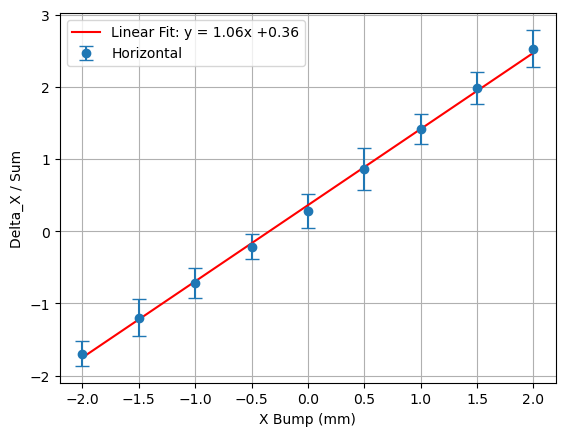

[0.16120522682339927, 0.24190970679227902, 0.19688172425300865, 0.16152151129857345, 0.22369879597740025, 0.27495012152493237, 0.1984804848190048, 0.2077221346309407, 0.2434522885421106]


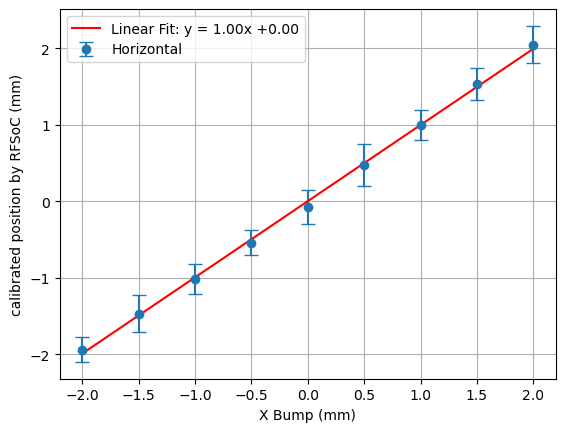

In [223]:
def linear_model(x, a, b):
    return a * x + b

params, covariance = curve_fit(linear_model, bamp, x_pos, sigma=x_std)
plt.rcParams["font.size"]=10
plt.errorbar(bamp, x_pos, yerr=x_std, capsize=5, fmt='o', label='Horizontal',color='tab:blue')
fit_line = linear_model(np.array(bamp), params[0] ,params[1])
plt.plot(bamp, fit_line, color='red', label=f'Linear Fit: y = {params[0]:.2f}x +{params[1]:.2f}')
plt.xlabel('X Bump (mm)')
plt.ylabel('Delta_X / Sum')
plt.legend()
plt.grid(True)
#plt.savefig('calib.png',dpi=200,bbox_inches='tight')
plt.show()


print(x_std_calib)
params, covariance = curve_fit(linear_model, bamp, x_pos_calib, sigma=x_std_calib)
plt.rcParams["font.size"]=10
plt.errorbar(bamp, x_pos_calib, yerr=x_std_calib, capsize=5, fmt='o', label='Horizontal',color='tab:blue')
fit_line = linear_model(np.array(bamp), params[0] ,params[1])
plt.plot(bamp, fit_line, color='red', label=f'Linear Fit: y = {params[0]:.2f}x +{params[1]:.2f}')
plt.xlabel('X Bump (mm)')
plt.ylabel('calibrated position by RFSoC (mm)')
plt.legend()
plt.grid(True)
#plt.savefig('calib.png',dpi=200,bbox_inches='tight')
plt.show()

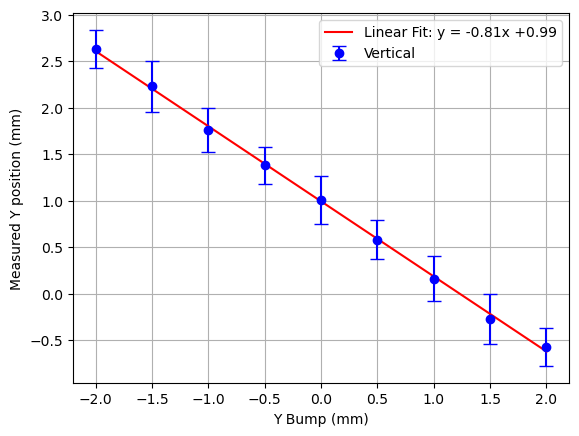

[0.251778147288603, 0.3378775843185793, 0.29456691125692547, 0.24753801796105185, 0.31900393185573167, 0.2582686972497138, 0.2951020394905972, 0.3327477110720029, 0.2548667574988629]


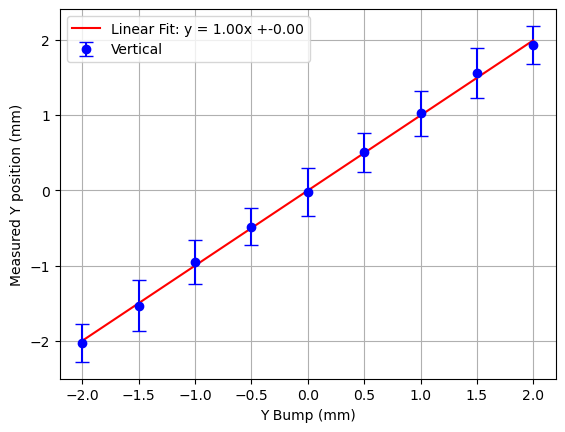

In [224]:
def linear_model(x, a, b):
    return a * x + b

params, covariance = curve_fit(linear_model, bamp, y_pos, sigma=y_std)
plt.rcParams["font.size"]=10
plt.errorbar(bamp, y_pos, yerr=y_std, capsize=5, fmt='o', label='Vertical',color='b')
fit_line = linear_model(np.array(bamp), params[0] ,params[1])
plt.plot(bamp, fit_line, color='red', label=f'Linear Fit: y = {params[0]:.2f}x +{params[1]:.2f}')
plt.xlabel('Y Bump (mm)')
plt.ylabel('Measured Y position (mm)')
plt.legend()
plt.grid(True)
#plt.savefig('calib.png',dpi=200,bbox_inches='tight')
plt.show()

print(y_std_calib)
params, covariance = curve_fit(linear_model, bamp, y_pos_calib, sigma=y_std_calib)
plt.rcParams["font.size"]=10
plt.errorbar(bamp, y_pos_calib, yerr=y_std_calib, capsize=5, fmt='o', label='Vertical',color='b')
fit_line = linear_model(np.array(bamp), params[0] ,params[1])
plt.plot(bamp, fit_line, color='red', label=f'Linear Fit: y = {params[0]:.2f}x +{params[1]:.2f}')
plt.xlabel('Y Bump (mm)')
plt.ylabel('Measured Y position (mm)')
plt.legend()
plt.grid(True)
#plt.savefig('calib.png',dpi=200,bbox_inches='tight')
plt.show()

